# Online News Popularity Dataset: Predicting the viral popularity of an article.


- Braden Sunderland
- Dylan De Lancie
- Manas Mridul (74732843)

## I. Project Introduction

In this project, we will look at the Online News Popularity dataset which contains the characteristics and performance values for 39,644 articles published on Mashable.com. 

Moreover, we ask: Can we use a KNN Classification model to reliably predict the popularity of an article given we know the avg. word length, the general sentiment, the day of publication and category of publication?

### I.A. Dataset Information

- The dataset can be accessed here: https://archive.ics.uci.edu/ml/datasets/Online+News+Popularity . There are 60 attributes recorded about each data entry.
- The target variable in the dataset is the dbl entitled ‘shares,’ which is simply the number of times the corresponding article was shared by readers via social networks.

### I. B. Methods
- We decided to create our own categorical classes (see section IIA). 
- We expect to use KNN classifier model for predictive analysis. However, this might change if our understanding of KNN Regression improves over next weeks (predict the Share numerical value rather than a categorical class).
- We will verify the performance of our model by refering to the confusion matrix. We'll also plot the accuracy estimates provided by a 5 fold vfold function against the 10 different values of K to find the optimal parameter K.

The 4 predictors we've included in our model are:
- average_token_length - Average length of the words in the content.
- global_sentiment_polarity- Polarity of entire article's sentiment, ranges from -1 to 1.
- day_of_week- day of week the article was published on. 
- data_channel- article's publication section (Lifestyle, Entertainment, Business, Social Media, Tech, World, Other) 

### I. C. Expected Outcomes and Significance

We hypothesize that articles with shorter avg. word length (being more readable) are more popular especially among younger audiences. We theorize highly polarized sentiments will induce readers to react strongly and share the article with their networks, increasing popularity. We expect articles posted on the days leading to a weekend will be more popular as more population has free time to read and share. Lastly, we hypothesize articles published in more human-relatable sections like entertainment and lifestyle to be more likely to be shared by readers. 

Any conclusive findings from our project would be significant for spheres of journalism and blogging alike. To evaluate the impact of negative polarized sentiment on popularity is to put in perspective the mainstream media’s “outrage sells” strategy. Additionally, authors might prefer to prioritize quality over quantity and only publish on the better-performing days of the week. Some authors may shift between publication channels, eg from low engagement segments to more popular ones. 

Some additional questions beyond the scope of this project:
What are the data channels that make up the Other category? Does the sports data channel account for the large number of viral articles in the other category? Are the shorter average word lengths a result of the article’s data channel i.e. would our model be as accurate with one of these two predictors removed?

## II. Setup and Reading Data

In [ ]:
library(tidyverse)
library(repr)
library(tidymodels)

options(repr.matrix.max.rows = 6) 

library(GGally)
library(RColorBrewer)

-----------------------------------------------------------------------------------------------------------------

In [ ]:
myFile <- "https://raw.githubusercontent.com/mmanas8/Game-results-for-Top-500-Players-2017-19-Dataset/master/online-news-popularity.csv" #ignore repository name
news_data <- read_csv(myFile)
head(news_data, 4)

### II.A. Creating our own categorical classifiers
Currently, the dataset's orginal target (class) is a continuous variable. We'd like to make our own categorical classes using what we know about the distribution of the variable 'shares'. We do this using 7 percentiles calculated from the data set we have. 


- Viral = Top 95%
- Highly Popular = Top 90%
- Popular = Top 80%
- Satisfactory = Top 60%
- Average = Top 50%
- Subpar = Top 35%
- Abysmal = Rest


In [5]:
data2 <- news_data %>%
         mutate(performance = case_when(shares <= 645 ~ "Abysmal", 
                                       shares > 645 & shares <= 861 ~ "Subpar",
                                       shares > 861 & shares <= 1400 ~ "Average",
                                       shares > 1400 & shares <= 31300 ~ "Satisfactory",
                                       shares > 31300 & shares <= 53700 ~ "Popular",
                                       shares > 53700 & shares <= 77200 ~ "Highly Popular",
                                       shares > 77200 ~ "Viral"))
                                
head(data2,4)

url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,⋯,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,performance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
http://mashable.com/2013/01/07/amazon-instant-video-browser/,731,12,219,0.6635945,1,0.8153846,4,2,1,⋯,0.7,-0.3500000,-0.600,-0.2000000,0.5,-0.1875,0.0,0.1875,593,Abysmal
http://mashable.com/2013/01/07/ap-samsung-sponsored-tweets/,731,9,255,0.6047431,1,0.7919463,3,1,1,⋯,0.7,-0.1187500,-0.125,-0.1000000,0.0,0.0000,0.5,0.0000,711,Subpar
http://mashable.com/2013/01/07/apple-40-billion-app-downloads/,731,9,211,0.5751295,1,0.6638655,3,1,1,⋯,1.0,-0.4666667,-0.800,-0.1333333,0.0,0.0000,0.5,0.0000,1500,Satisfactory
http://mashable.com/2013/01/07/astronaut-notre-dame-bcs/,731,9,531,0.5037879,1,0.6656347,9,0,1,⋯,0.8,-0.3696970,-0.600,-0.1666667,0.0,0.0000,0.5,0.0000,1200,Average


## III. Data Wrangling

In [6]:
#Combine the multiple vectors relating to data_channel into a single vector using mutate.

data_narrower <- data2 %>%
          mutate(data_channel = ifelse(data_channel_is_lifestyle == 1, "Lifestyle",
                    ifelse(data_channel_is_entertainment == 1, "Entertainment",
                    ifelse(data_channel_is_bus == 1, "Business",
                    ifelse(data_channel_is_socmed == 1, "Social Media", 
                    ifelse(data_channel_is_tech == 1, "Technology",
                    ifelse(data_channel_is_world == 1, "World", "Other"))))))) %>%
#Combine the multiple vectors relating to weekday into a single vector using mutate.
                 mutate(day_of_week = ifelse(weekday_is_monday == 1, "Monday",
                    ifelse(weekday_is_tuesday == 1, "Tuesday",
                    ifelse(weekday_is_wednesday == 1, "Wednesday",
                    ifelse(weekday_is_thursday == 1, "Thursday", 
                    ifelse(weekday_is_friday == 1, "Friday",
                    ifelse(weekday_is_saturday == 1, "Saturday",
                    ifelse(weekday_is_sunday == 1, "Sunday", "N/A")))))))) %>%
                
                 select(-data_channel_is_lifestyle, -data_channel_is_entertainment, -data_channel_is_bus, -data_channel_is_socmed, -data_channel_is_tech,
                       -data_channel_is_world, -weekday_is_monday, -weekday_is_tuesday, -weekday_is_wednesday, -weekday_is_thursday, -weekday_is_friday,
                       -weekday_is_saturday, -weekday_is_sunday)

tail(data_narrower, 2)

url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,⋯,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,performance,data_channel,day_of_week
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
http://mashable.com/2014/12/27/ukraine-blasts/,8,6,682,0.5394933,1,0.6926605,10,1,1,⋯,-0.5,-0.0125,0.0000000,0.00,0.5000000,0.00,1100,Average,World,Wednesday
http://mashable.com/2014/12/27/youtube-channels-2015/,8,10,157,0.7019868,1,0.8461538,1,1,0,⋯,-0.2,-0.2000,0.3333333,0.25,0.1666667,0.25,1300,Average,Entertainment,Wednesday


## IV. Creating Stratified Random Test/Train Splits

We now partition `data_narrower` into a training (75%) and testing (25%) set using the `tidymodels` package.

In [7]:
set.seed(3456)

news_split <- initial_split(data_narrower, prop = 0.75, strata = performance)  
news_train <- training(news_split)   
news_test <- testing(news_split)


In [8]:
head(news_train, 4)

url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,⋯,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,performance,data_channel,day_of_week
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
http://mashable.com/2013/01/07/amazon-instant-video-browser/,731,12,219,0.6635945,1,0.8153846,4,2,1,⋯,-0.6,-0.2000000,0.5000000,-0.1875000,0.0000000,0.1875000,593,Abysmal,Entertainment,Monday
http://mashable.com/2013/01/07/apple-40-billion-app-downloads/,731,9,211,0.5751295,1,0.6638655,3,1,1,⋯,-0.8,-0.1333333,0.0000000,0.0000000,0.5000000,0.0000000,1500,Satisfactory,Business,Monday
http://mashable.com/2013/01/07/astronaut-notre-dame-bcs/,731,9,531,0.5037879,1,0.6656347,9,0,1,⋯,-0.6,-0.1666667,0.0000000,0.0000000,0.5000000,0.0000000,1200,Average,Entertainment,Monday
http://mashable.com/2013/01/07/beewi-smart-toys/,731,10,370,0.5598886,1,0.6981982,2,2,0,⋯,-0.4,-0.1000000,0.6428571,0.2142857,0.1428571,0.2142857,855,Subpar,Technology,Monday


</br>

</br>

## V. Exploratory Analysis using `news_train`

`summarise()` ungrouping output (override with `.groups` argument)



# A tibble: 7 x 2
  performance        n
  <chr>          <int>
1 Abysmal         2168
2 Average         9290
3 Highly Popular    62
4 Popular          182
5 Satisfactory   14364
6 Subpar          3596
7 Viral             73


average_token_length,global_sentiment_polarity
<dbl>,<dbl>
4.545184,0.1195544


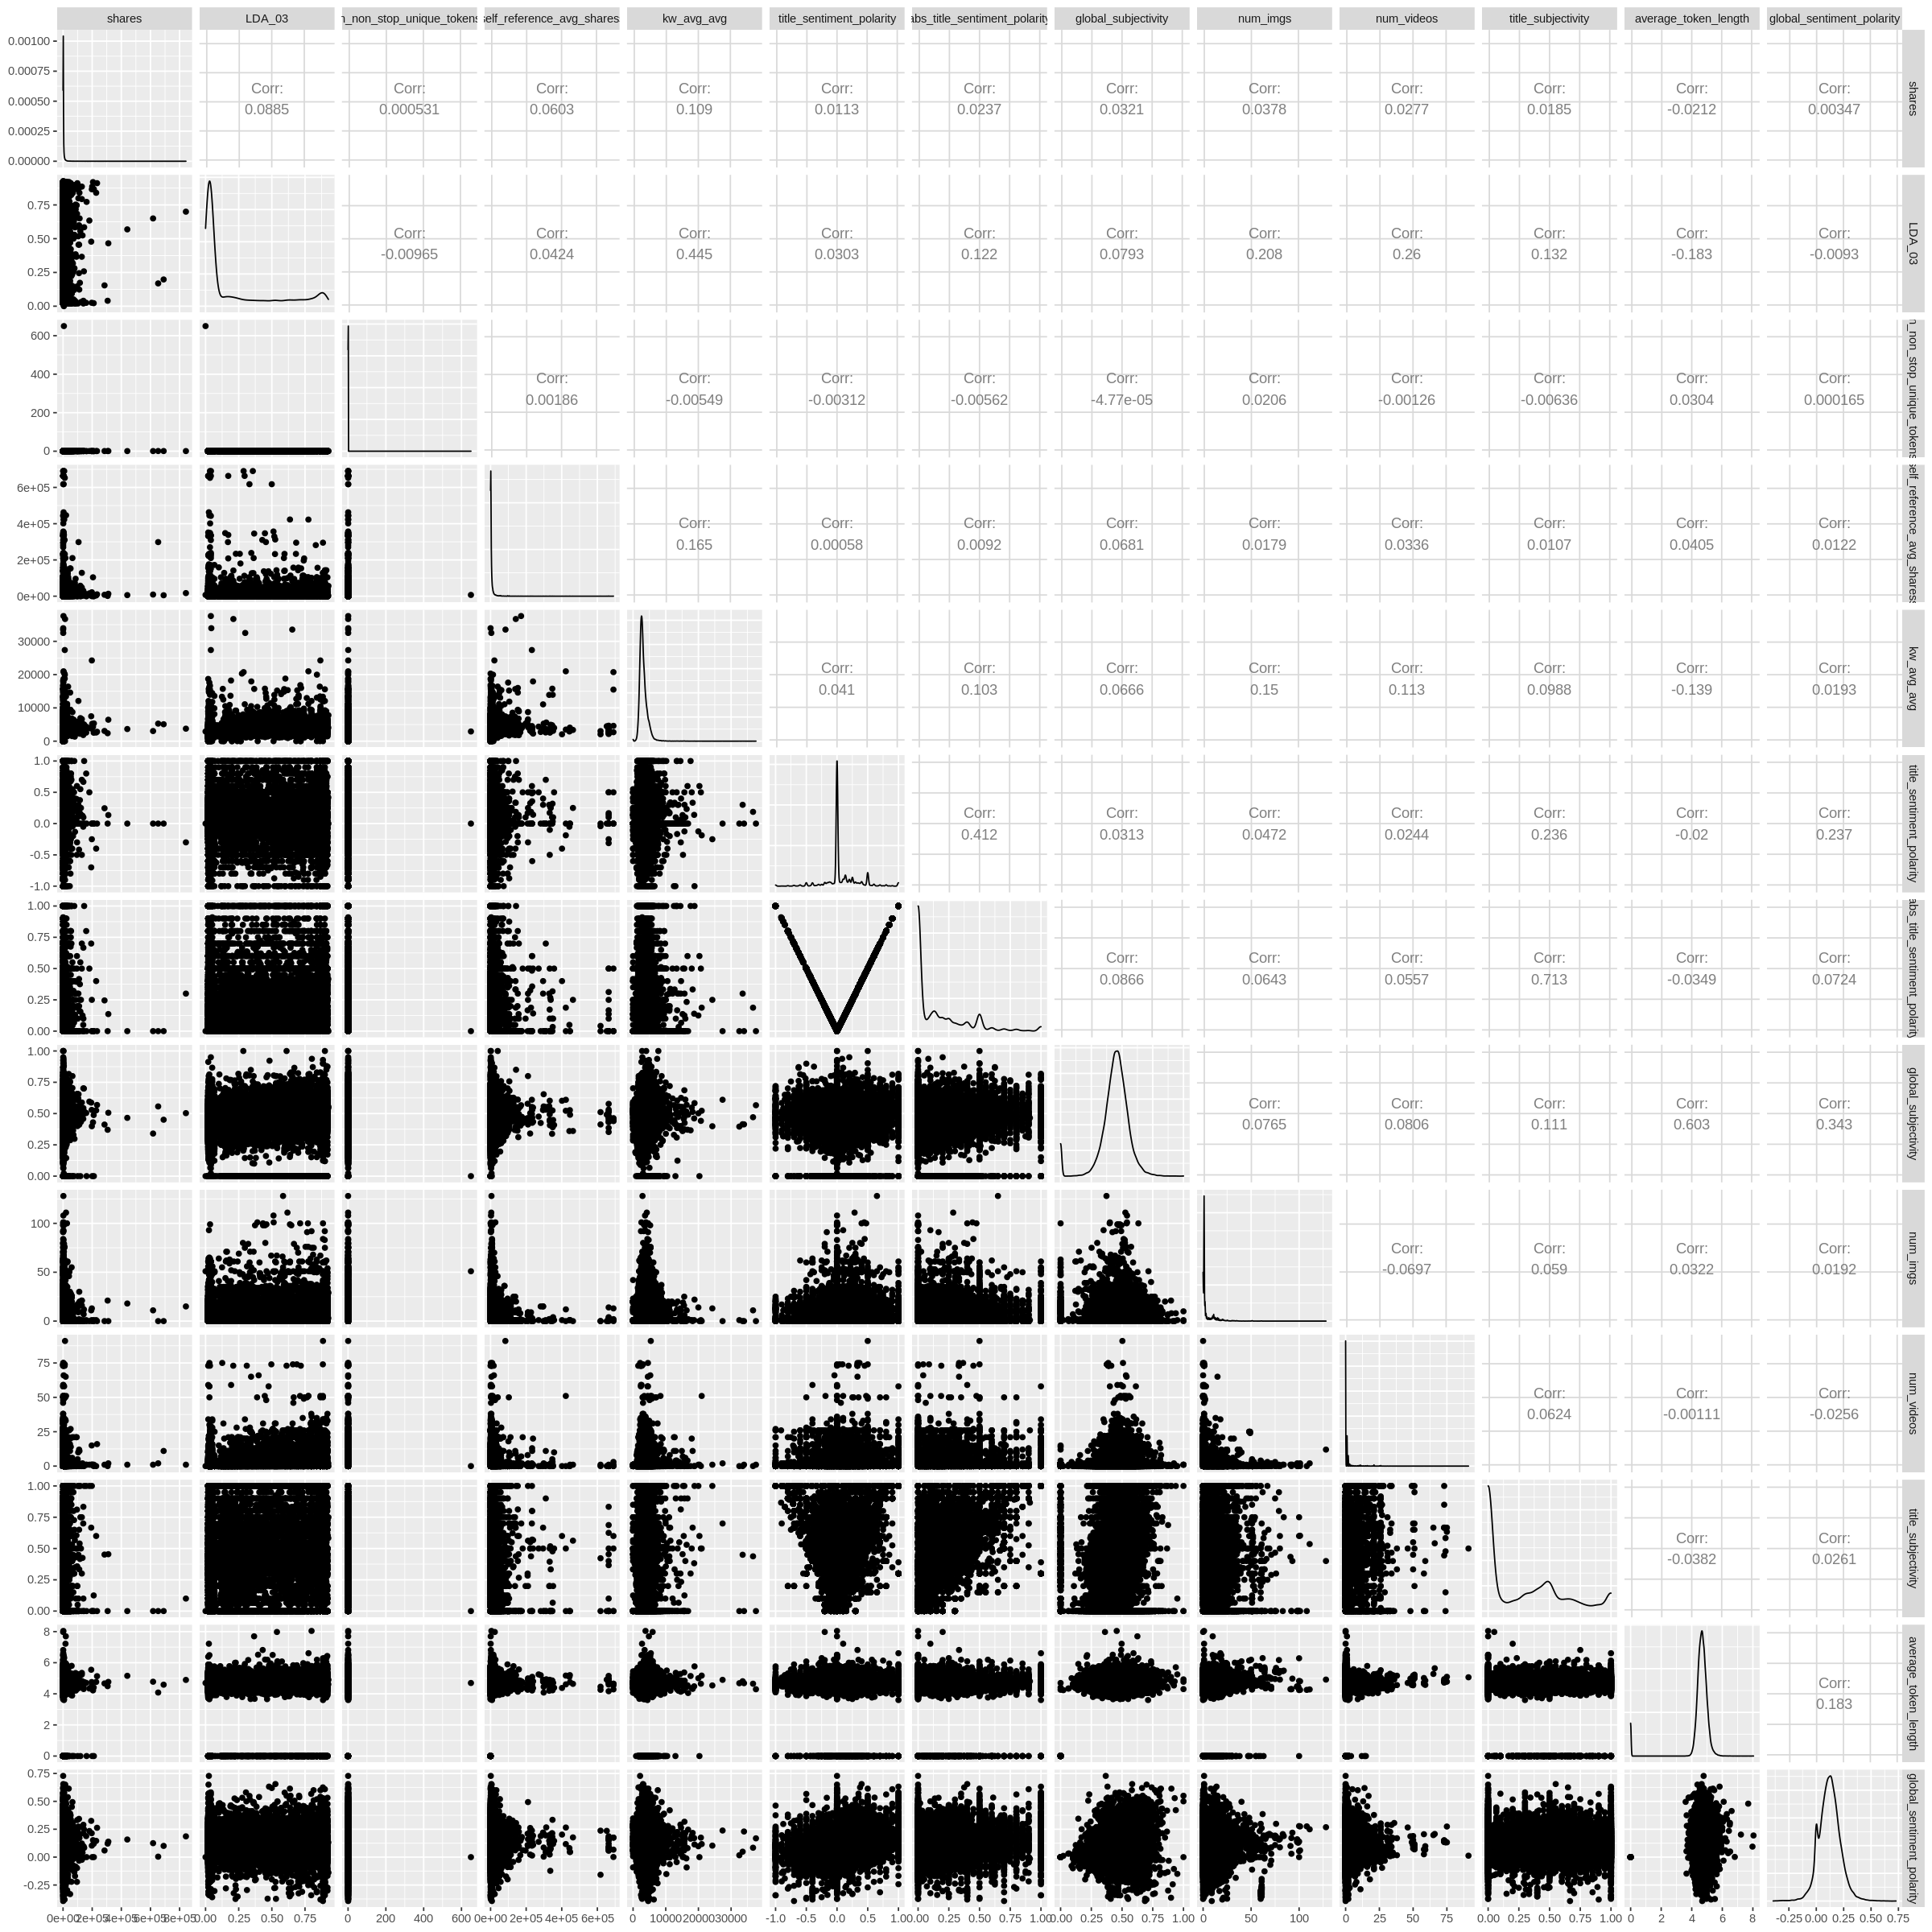

In [37]:
#Means of predictors in train
means_train <- news_train %>%
               select(average_token_length, global_sentiment_polarity) %>%
               map_df(mean, na.rm = TRUE)

#the number of observations in each of the 6 classes
dist_classes <- news_train %>%
                group_by(performance) %>%
                summarise(n = n())
options(repr.plot.width = 20, repr.plot.height = 20)
pairs <- news_train %>%
         select(shares, LDA_03, n_non_stop_unique_tokens, self_reference_avg_sharess, kw_avg_avg, title_sentiment_polarity, abs_title_sentiment_polarity, global_subjectivity, num_imgs, num_videos, title_subjectivity, average_token_length, global_sentiment_polarity) %>%
         ggpairs()
pairs
         
print(dist_classes, 7)

means_train

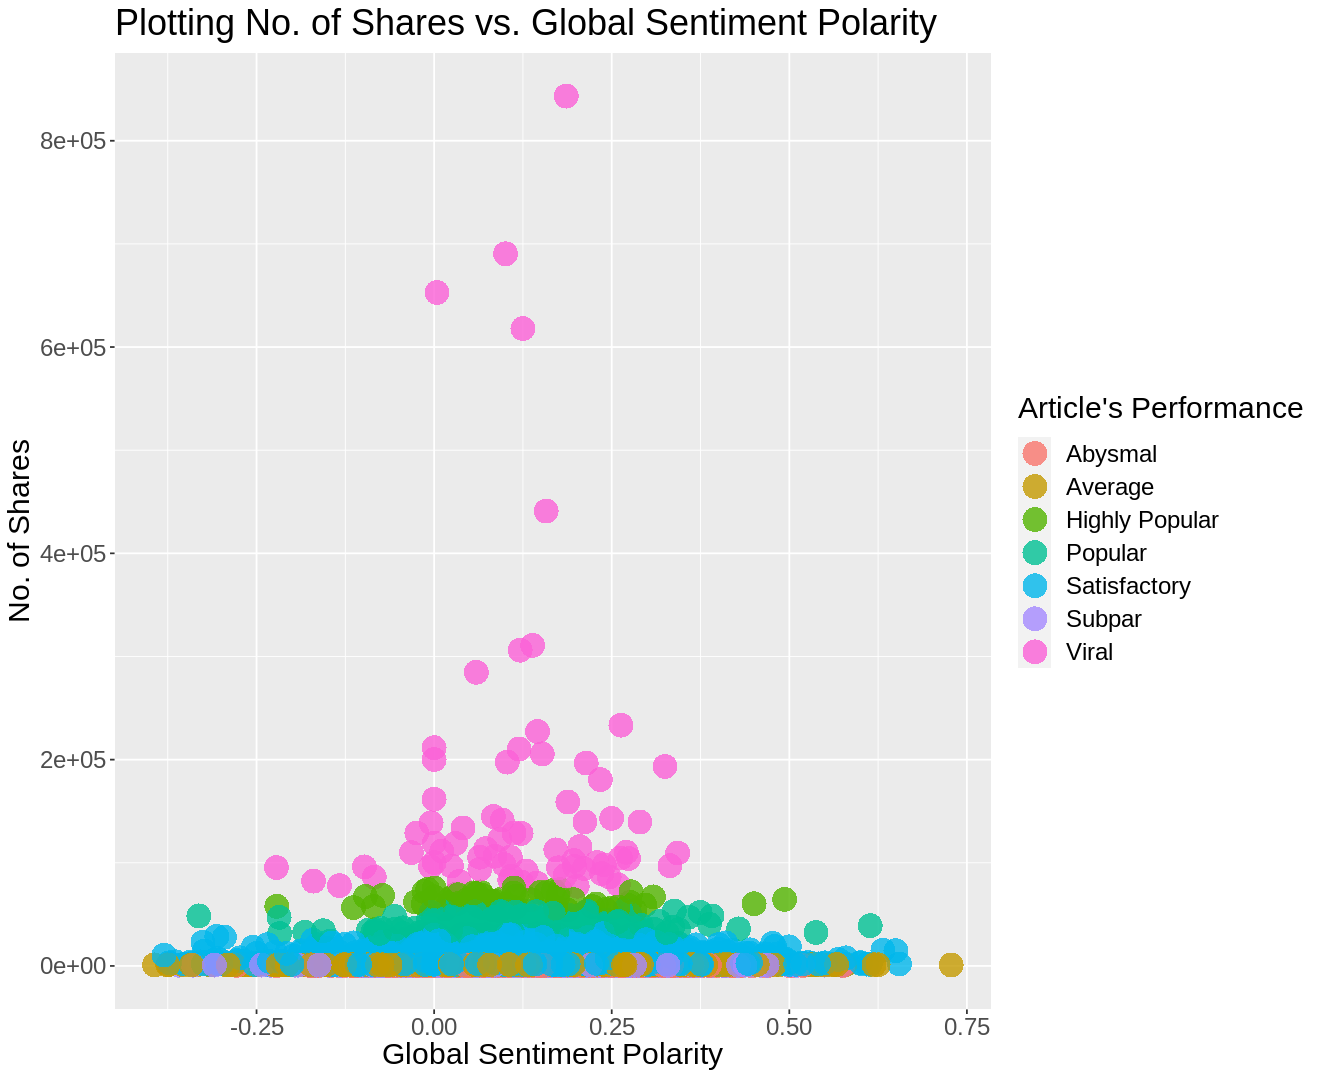

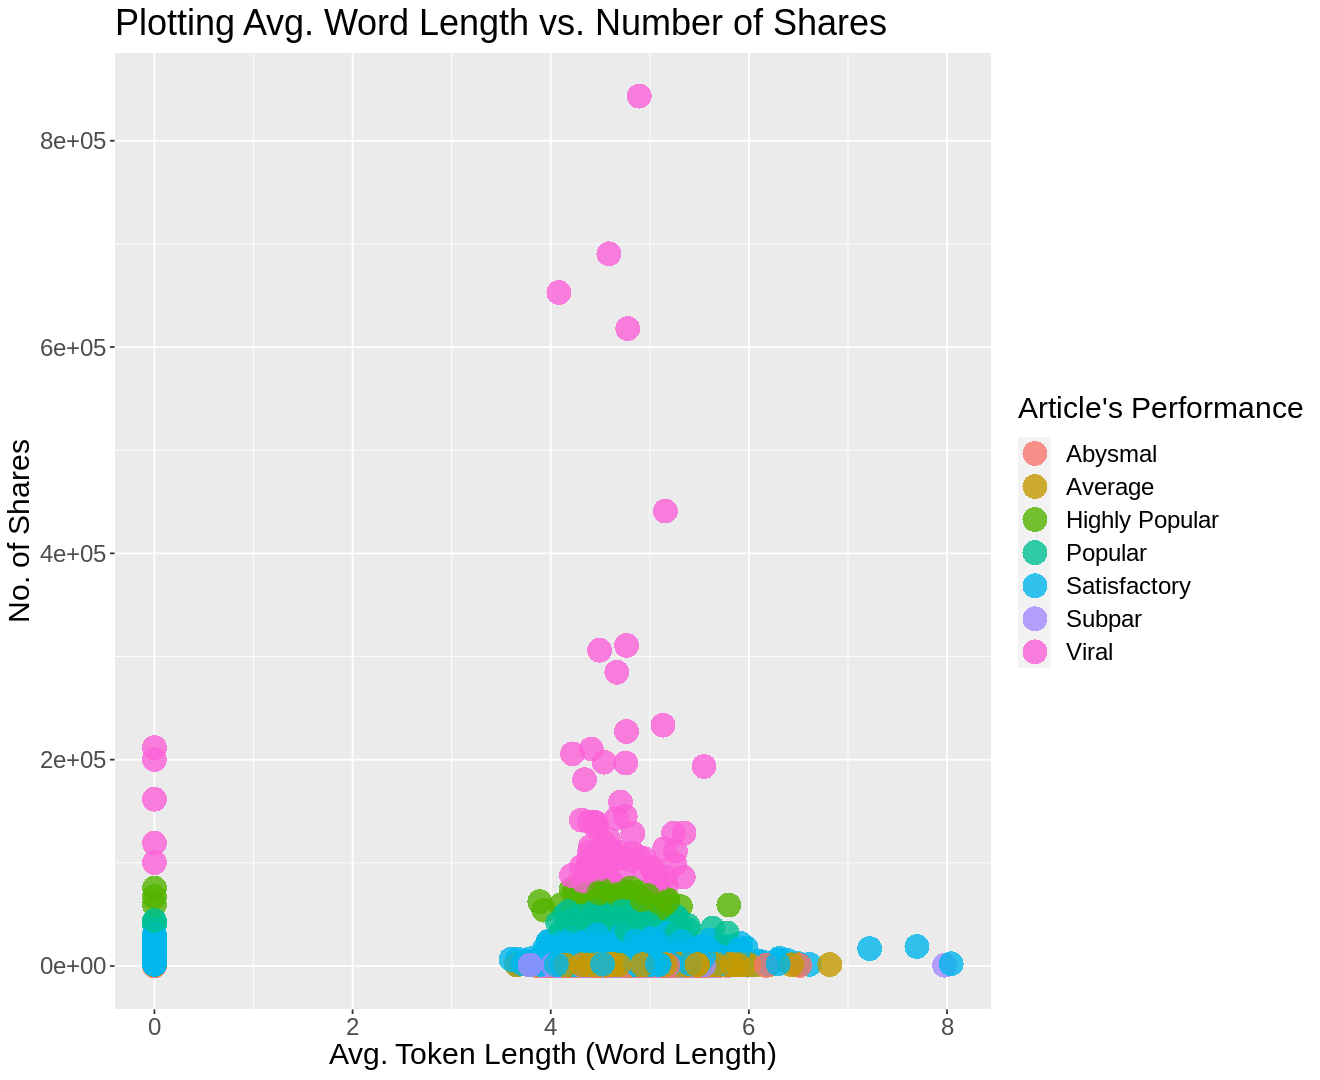

In [155]:
options(repr.plot.width = 11, repr.plot.height = 9)
plot1 <- news_train %>%
         ggplot(aes(global_sentiment_polarity, shares, color = performance)) +
         geom_point(alpha = 0.8, size = 7, stroke = 0) +
         labs(x = "Global Sentiment Polarity", y = "No. of Shares", colour = "Article's Performance") +
         theme(text = element_text(size = 18)) +
         ggtitle("Plotting No. of Shares vs. Global Sentiment Polarity") +
         scale_fill_brewer(palette = "Set3")


plot1

plot2 <- news_train %>%
         ggplot(aes(average_token_length, shares, color = performance)) +
         geom_point(alpha = 0.8, size = 7, stroke = 0) +
         labs(x = "Avg. Token Length (Word Length)", y = "No. of Shares", colour = "Article's Performance") +
         theme(text = element_text(size = 18)) +
         ggtitle("Plotting Avg. Word Length vs. Number of Shares") +
         scale_fill_brewer(palette = "Set3")


plot2

#### Insights from Plot 1 & 2:
- The most exceptional articles had moderate Global Sentiment Polarity (approx. range between 0.00 and 0.30). This definitely challenged our preconceived notions and hypothesis that more polarizing articles must correspond to higher popularity.
- This plot tells us that a mildy polarizing article might be the sweet spot for garnering higher shares. This could be supported by a guess that mildly polarizing articles are able to appeal to a wider range of audiences while still offering some senses of excitement, sensation as compared to almost neutral articles. 

</br>

`summarise()` regrouping output by 'day_of_week' (override with `.groups` argument)



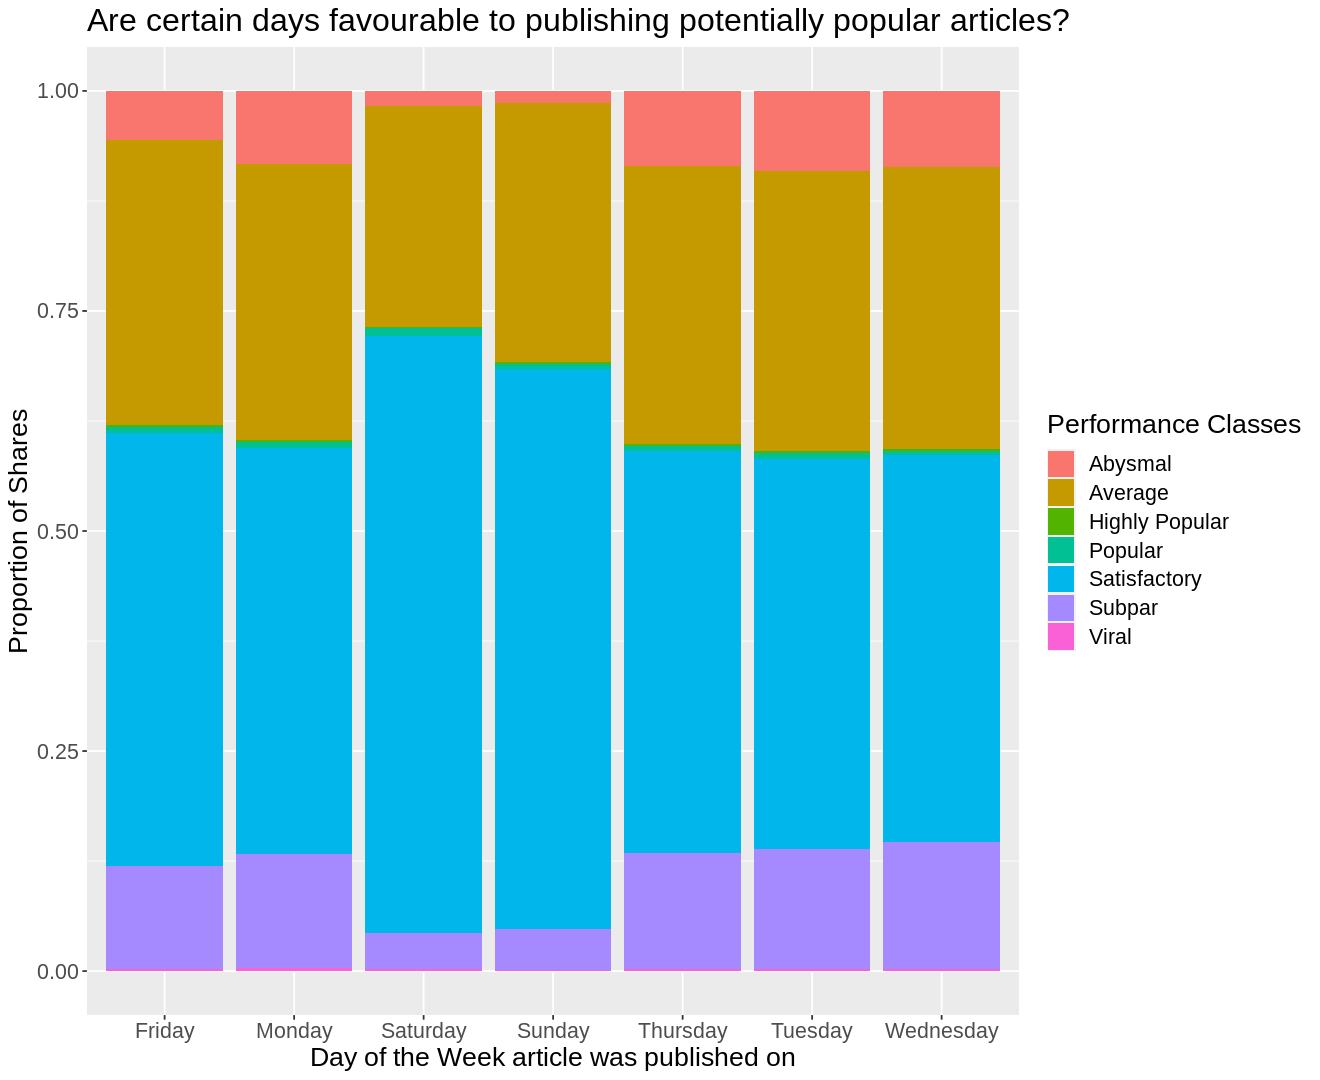

In [156]:
#Now we create a plot that compares the days of week with regards to articles' performances

plot3 <- news_train %>%
         group_by(day_of_week, performance) %>%
         summarise(n = n()) %>%
         ggplot(aes(day_of_week, n, fill = performance)) +
         geom_bar(stat = "identity", position = "fill") +
         labs(x = "Day of the Week article was published on", y = "Proportion of Shares", fill = "Performance Classes") +
         ggtitle("Are certain days favourable to publishing potentially popular articles? ") +
         theme(text = element_text(size = 16))

plot3


### Insights from Plot 3:
- Satisfactory posts account for the largest proportion of daily articles throughout the week. 
- Saturday and Sunday are the days when proportions of Absymal and Subpar articles are significantly reduced. Good days to achieve satisfactory and average amounts of shares.
- Monday and Saturday seem as potential candidates for achieving viral popularity, however the differences are almost negligible throughout the week.

`summarise()` regrouping output by 'data_channel' (override with `.groups` argument)



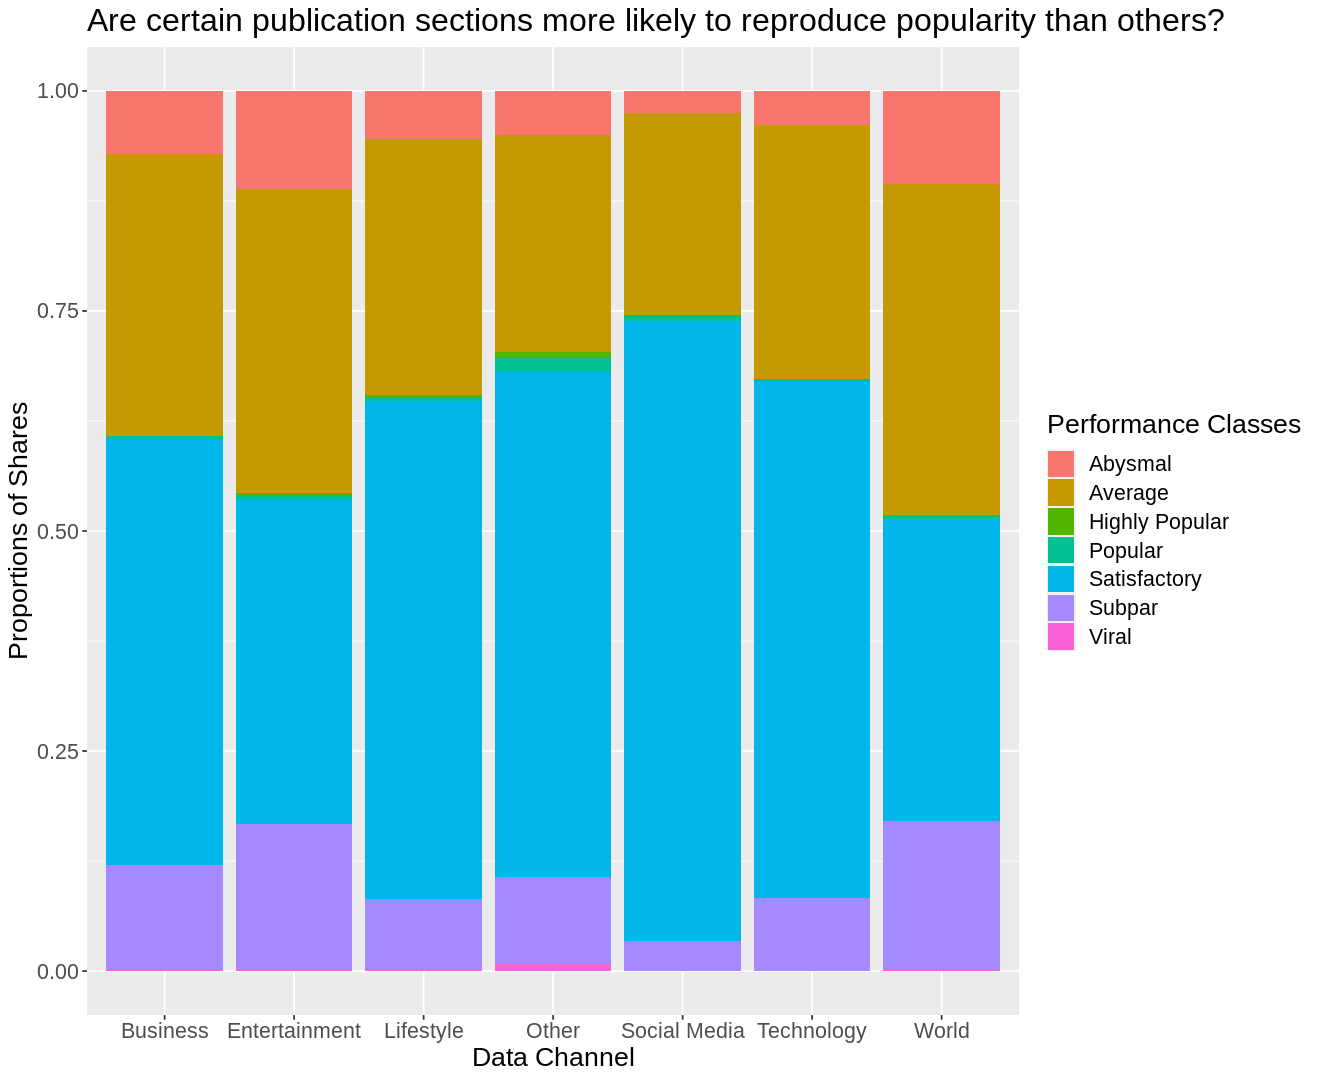

In [157]:
#Now we create a plot that compares the different data channels with regards to articles' performances

plot4 <- news_train %>%
         group_by(data_channel, performance) %>%
         summarise(n = n()) %>%
         ggplot(aes(data_channel, n, fill = performance)) +
         geom_bar(stat = "identity", position = "fill") +
         labs(x = "Data Channel", y = "Proportions of Shares", fill = "Performance Classes") +
         ggtitle("Are certain publication sections more likely to reproduce popularity than others?") +
         theme(text = element_text(size = 16))

plot4


### Insights from Plot 4
- Contrary to our notions, Entertainment section doesn't perform as well. Along with the World section, Entertainment has the highest proportion of Abysmal and Subpar articles.
- Social Media section is generally a reliable choice to reproduce Satisfactory levels of shares, and it has the smallest proportion of Subpar and Abysmal articles. 
- Those in search of viral popularity *might* have to look towards the Other section. While we're sure what this section is not (it's not Business or World or any other channel in the plot), we might be interested in exploring which kind of channels might be included in Other channel that have the potential to produce relatively higher proportion of Viral and Popular posts as compared to other channels.